In [1]:
# Set up the environment
from matplotlib import pyplot as plt
from myst_nb import glue

import xml_book.meta_explainers.plot_examples as plot_examples

(text:meta-explainers:surrogates)=
# Surrogates #

```{admonition} Explainer Summary
:class: important, dropdown

Surrogate explainers construct an inherently interpretable model to approximate a more complex, opaque decision boundary in a desired subspace.

| *Property*           | **Surrogate Explainers**                              |
|----------------------|-------------------------------------------------------|
| *relation*           | post-hoc                                              |
| *compatibility*      | model-agnostic / (semi-)supervised                    |
| *modelling*          | regression, crisp and probabilistic classification    |
| *scope*              | local, cohort or global                               |
| *target*             | prediction or model                                   |
| *data*               | text, image or tabular (data-universal)               |
| *features*           | numerical and categorical (tabular data)              |
| *explanation*        | type depends on the surrogate model                   |
| *caveats*            | random sampling, explanation faithfulness             |
```

Surrogate explainers construct an inherently interpretable model in a desired -- local, cohort or global -- subspace to approximate a more complex, black-box decision boundary {cite:p}`craven1996extracting,ribeiro2016why,sokol2019blimey`.
An intuitive visualisation of this process for tabular data is shown in {numref}`fig:surrogates:overview`, where the red and blue areas capture two different classes determined by two continuous features.
While in this example the surrogate is a *linear* model fitted *locally* within a specific neighbourhood, different classifiers can be used to generate other types of explanations -- while linear models offer feature influence {cite:p}`ribeiro2016why`, decision trees, for example, can provide feature importance and counterfactuals {cite:p}`waa2018contrastive,sokol2020limetree`.
Furthermore, this simplistic depiction of surrogates should not be taken at its face value as these explainers often rely on custom *{term}`interpretable representations<interpretable representation>`* -- which transform raw features into human-intelligible concepts {cite:p}`sokol2020towards` -- in which case understanding their behaviour as well as properties and limitations of the resulting explanations require more nuance.
If poorly fitted, the surrogate model may output untrustworthy (and possibly misleading) insights, therefore its *{term}`fidelity`* -- which captures the quality of black-box decision boundary approximation -- should be evaluated and maximised {cite:p}`rudin2019stop`.
For the example shown in {numref}`fig:surrogates:overview` this property is determined by the alignment between the dashed line (surrogate model) and the fragment of the red--blue decision boundary of the black box chosen to be explained.

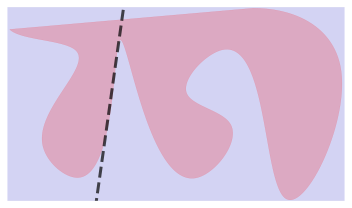

<Figure size 360x216 with 0 Axes>

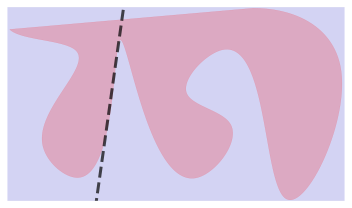

In [2]:
fig, ax = plot_examples.local_linear_surrogate(figsize=(5, 3))
glue('fig_surrogates_overview', fig, display=False)

```{glue:figure} fig_surrogates_overview
:figwidth: 95%
:name: "fig:surrogates:overview"

A visualisation of a *local*, *linear* surrogate model -- the black, dashed line -- for two-dimensional tabular data with two classes.
The explanation is generated by extracting feature coefficients from this model.
```
<!-- :alt: "Local, linear surrogate explainer for two-dimensional tabular data." -->

```{warning}
While {numref}`fig:surrogates:overview` offers a good idea of surrogate explainers, this intuition may be misleading when dealing with their more complex instantiations.
For example, if they are built atop an {term}`interpretable representation`, they do not *directly* approximate a black-box decision surface but instead capture its behaviour through the prism of concepts encoded by the interpretable representation.
```

<h2> Overview of Surrogate Explainers </h2>

Surrogates are an attractive explainability approach as they are *post-hoc* and *model-agnostic*, i.e., they can be retrofitted into a pre&euml;xisting black-box model regardless of its type.
Additionally, they can be applied to a range of diverse modelling problems across regression as well as crisp and probabilistic classification tasks.
Surrogate explainers are also *data-universal* due to the use of interpretable representations, therefore they work with text, image and tabular (with both numerical and categorical features) data.
For text and tabular data their local, cohort or global scope can be easily adjusted; however, for images they are predominantly local, i.e., valid only with respect to a single image.
This flexibility allows them to target an individual prediction, a group thereof, or scale up all the way to mimicking, hence simplifying, an entire black-box model.

A wide selection of transparent models that can be used as surrogates enables these explainers to provide a broad range of explanation types.
For example, decision trees can offer {term}`counterfactuals<counterfactual>` and {term}`feature importance` {cite:p}`waa2018contrastive,sokol2020limetree`, whereas linear classifiers deliver {term}`feature influence` {cite:p}`ribeiro2016why`.
While this diversity may be alluring, it comes at a cost.
Since the explanations are extracted from a surrogate model, they may not be truthful with respect to the underlying black box, i.e., exhibit **poor** *fidelity*.
Even when we explicitly optimise for faithfulness, it may be impossible to guarantee that the surrogate explanations capture the exact characteristics of the black-box decision boundary.
Additionally, surrogates rely on (**random**) *data sampling* to discover the behaviour of the explained model in a selected neighbourhood.

LIME -- Local Interpretable Model-agnostic Explanations {cite:p}`ribeiro2016why` -- is one of the most popular surrogate explainers but it is just a single instantiation of their much broader family.
To cover the breadth and depth of this explainer type, this chapter is based on the bLIMEy -- build LIME yourself {cite:p}`sokol2019blimey` -- meta-algorithm.
It provides a generalisation of LIME into a flexible framework that supports building bespoke surrogate explainers that are appropriate for the problem at hand and exhibit the desired properties.
bLIMEy has three algorithmic steps.

1. *Interpretable representation composition.*
   If desired, data are transformed from their original domain into a human-intelligible representation, which is used to convey the explanations.
   For example, {term}`super-pixel` segmentation of images; {term}`bag-of-words` representation of text; and discretisation of continuous features for tabular data.
   While this step is required for the former two domains, it is not necessary -- albeit helpful -- for the latter.
2. *Data sampling.*
   To capture the behaviour of a black box in a desired subspace, a data sample is generated and predicted by the explained model.
3. *Explanation generation.*
   Explanatory insights are extracted from an inherently transparent model fitted into the data sampled in the previous step, using their black-box predictions as the target.
   Additional processing steps can be applied to tune and tweak the surrogate model, hence the explanation.
   For example, the sample can be *weighted* based on its proximity to the explained instance when dealing with local explanations; and a feature selection procedure may be used to introduce sparsity, therefore improve accessibility and comprehensibility of explanatory insights.

These steps are operationalised differently depending on the type of data, hence their algorithmic approaches are covered by separate sections of this chapter (see the table below).
A visual depiction of a step-by-step process of building a *local*, *linear* surrogate for two-dimensional *tabular data* *without an interpretable representation* is captured by {numref}`fig:surrogates:full_overview`.

<h2> High-level Summary </h2>

Surrogate explainers may be a good solution, or should be avoided, depending on individual circumstances.

<h3> Pros </h3>

- A universal inspection mechanism for various subspaces of an arbitrary black-box algorithmic decision process.
- Highly customisable.
- A single explanatory procedure for image, text and tabular data.
- Produces diverse explanation types depending on the utilised surrogate model.
- Outputs intuitive explanations for image and text data due to the use of interpretable representations.

<h3> Cons </h3>

- Inadequate for high-stakes algorithmic decisions because of lacklustre fidelity {cite:p}`rudin2019stop`.
- Explanations may be counterintuitive and misleading for a lay audience when applied to tabular data *with* an interpretable representation.
- While post-hoc, model-agnostic and data-universal, they must not be treated as a silver bullet.
- Their characteristics allow a single instantiation of a surrogate explainer to be applied to diverse problems, however the quality of the resulting explanations will vary across different problems and data sets.
- Building them requires an effort since each explainer should be tweaked and tuned to the problem at hand.

<h2> Popular Surrogate Explainers </h2>

The following approaches are popular in the space of surrogate explainers.

- LIME -- Local Interpretable Model-agnostic Explanations {cite:p}`ribeiro2016why` -- is a *local* surrogate explainer based on a *linear model*. Its explanations capture the influence of human-intelligible components, which are determined by the underlying interpretable representation, on a selected black-box prediction. It works with text, image and tabular data.
- bLIMEy -- build LIME yourself {cite:p}`sokol2019blimey` -- is a surrogate meta-algorithm that provides a generic framework for building bespoke surrogate explainers.

{numref}`text:meta-explainers:surrogates:overview:literature` offers a broader overview of relevant literature.

<h2> Implementations </h2>

The following software packages implement surrogate explainers.
Note that many packages only offer an interface to the official LIME implementation; these instances are marked with the {far}`lemon` symbol.

```{list-table}
:header-rows: 1

* - {fab}`python` Python
  - {fab}`r-project` R
* - [LIME](https://github.com/marcotcr/lime)
  - [lime](https://github.com/thomasp85/lime)
* - [interpret](https://github.com/interpretml/interpret) {far}`lemon`
  - [iml](https://github.com/christophM/iml)
* - [Skater](https://github.com/oracle/Skater) {far}`lemon`
  -
* - [AIX360](https://github.com/Trusted-AI/AIX360) {far}`lemon`
  -
```

<h2> Contents of This Chapter </h2>

This chapter is split into sections dedicated to different types of data, which are further subdivided into three components of surrogate explainers.
Specifically, image and tabular data are discussed.

```{list-table}
:header-rows: 1

* - Images
  - Tabular
* - {numref}`Overview (§%s)<text:meta-explainers:surrogates:image>`
  - {numref}`Overview (§%s)<text:meta-explainers:surrogates:tabular>`
* - {numref}`Interpretable Representation (§%s)<text:meta-explainers:surrogates:image:interpretable-representation>`
  - {numref}`Interpretable Representation (§%s)<text:meta-explainers:surrogates:tabular:interpretable-representation>`
* - {numref}`Data Sampling (§%s)<text:meta-explainers:surrogates:image:data-sampling>`
  - {numref}`Data Sampling (§%s)<text:meta-explainers:surrogates:tabular:data-sampling>`
* - {numref}`Explanation Generation (§%s)<text:meta-explainers:surrogates:image:explanation-generation>`
  - {numref}`Explanation Generation (§%s)<text:meta-explainers:surrogates:tabular:explanation-generation>`
```